## Imports

Imports for Siamese RCNN

In [1]:
%load_ext autoreload
%autoreload 2A
%matplotlib inline
#%load_ext line_profiler

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.INFO)
sess_config = tf.ConfigProto()

import sys
import os

MASK_RCNN_MODEL_PATH = 'lib/Mask_RCNN/'

if MASK_RCNN_MODEL_PATH not in sys.path:
    sys.path.append(MASK_RCNN_MODEL_PATH)
    
from mrcnn import utils
from mrcnn import model as modellib
from mrcnn import visualize
    
from lib import utils as siamese_utils
from lib import model as siamese_model
from lib import config as siamese_config
   
import time
import datetime
import random
import numpy as np
import skimage.io
import imgaug
import pickle
import matplotlib.pyplot as plt
from collections import OrderedDict

import numpy as np
from math import floor

import colorsys

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

Using TensorFlow backend.


Imports for One-shot object detector

In [2]:
import os
import argparse
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms

from os2d.modeling.model import build_os2d_from_config
from os2d.config import cfg
import os2d.utils.visualization as visualizer
from os2d.structures.feature_map import FeatureMapSize
from os2d.utils import setup_logger, read_image, get_image_size_after_resize_preserving_aspect_ratio

# logger = setup_logger("OS2D")

Siamese model config

In [3]:
class LargeEvalConfig(siamese_config.Config):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1
    NAME = 'test'
    EXPERIMENT = 'evaluation'
    CHECKPOINT_DIR = 'checkpoints/'
    NUM_TARGETS = 1
    
    # Large image sizes
    TARGET_MAX_DIM = 192
    TARGET_MIN_DIM = 100
    IMAGE_MIN_DIM = 100
    IMAGE_MAX_DIM = 512
    # Large model size
    FPN_CLASSIF_FC_LAYERS_SIZE = 1024
    FPN_FEATUREMAPS = 256
    # Large number of rois at all stages
    RPN_ANCHOR_STRIDE = 1
    RPN_TRAIN_ANCHORS_PER_IMAGE = 256
    POST_NMS_ROIS_TRAINING = 2000
    POST_NMS_ROIS_INFERENCE = 1000
    TRAIN_ROIS_PER_IMAGE = 200
    DETECTION_MAX_INSTANCES = 100
    MAX_GT_INSTANCES = 100

In [4]:
# The small model trains on a single GPU and runs much faster.
# The large model is the same we used in our experiments but needs multiple GPUs and more time for training.
model_size = 'large' # or 'large'
config = LargeEvalConfig()
# config = SmallEvalConfig()
# config.display()

### Download models

In [5]:
cd checkpoints

/home/mmarfeychuk/dev/personal/masked_test/checkpoints


In [6]:
!wget https://github.com/bethgelab/siamese-mask-rcnn/releases/download/v0.2/large_siamese_mrcnn_coco_full_0320.h5

In [7]:
cd ..

/home/mmarfeychuk/dev/personal/masked_test


In [8]:
checkpoint = 'checkpoints/large_siamese_mrcnn_coco_full_0320.h5'
# checkpoint = 'checkpoints/small_siamese_mrcnn_0160.h5'

In [9]:
!./os2d/utils/wget_gdrive.sh models/os2d_v2-train.pth 1l_aanrxHj14d_QkCpein8wFmainNAzo8

Create model object

In [10]:
# Create model object in inference mode.
config.NUM_TARGETS = 1
model = siamese_model.SiameseMaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)
model.load_checkpoint(checkpoint)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
loading checkpoints/large_siamese_mrcnn_coco_full_0320.h5 ...
starting from epoch 320







In [11]:
cfg.init.model = "models/os2d_v2-train.pth"
net, box_coder, _, img_normalization, _ = build_os2d_from_config(cfg)

Load dataset for one-shot object detection

In [37]:
input_image = read_image("data/test.jpg")
class_images = [read_image("data/dataset1/target_1/target.jpg"),
                read_image("data/dataset1/target_2/target.jpg"),
                read_image("data/dataset1/target_3/target.jpg"),
                read_image("data/dataset1/target_4/target.jpg"),
                read_image("data/dataset1/target_5/target.jpg"),
                read_image("data/dataset1/target_6/target.jpg"),
                read_image("data/dataset1/target_7/target.jpg"),
                read_image("data/dataset1/target_8/target.jpg"),
                read_image("data/dataset1/target_9/target.jpg"),
                read_image("data/dataset1/target_10/target.jpg"),
                read_image("data/dataset1/target_11/target.jpg"),
                read_image("data/dataset1/target_12/target.jpg"),
                read_image("data/dataset1/target_13/target.jpg"),
                read_image("data/dataset1/target_14/target.jpg"),
                read_image("data/dataset1/target_15/target.jpg"),
                read_image("data/dataset1/target_16/target.jpg"),
                read_image("data/dataset1/target_17/target.jpg"),
                read_image("data/dataset1/target_18/target.jpg"),
                read_image("data/dataset1/target_19/target.jpg"),
                read_image("data/dataset1/target_20/target.jpg"),
                read_image("data/dataset1/target_21/target.jpg"),
                read_image("data/dataset1/target_22/target.jpg"),
                read_image("data/dataset1/target_23/target.jpg"),
                read_image("data/dataset1/target_24/target.jpg"),
                read_image("data/dataset1/target_25/target.jpg"),
                read_image("data/dataset1/target_26/target.jpg"),
                read_image("data/dataset1/target_27/target.jpg")]
class_ids = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16 ,17, 18, 19, 20, 21, 22, 23, 24, 25, 26]


Data manipulation and prediction

In [38]:
transform_image = transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Normalize(img_normalization["mean"], img_normalization["std"])
                      ])

h, w = get_image_size_after_resize_preserving_aspect_ratio(h=input_image.size[1],
                                                               w=input_image.size[0],
                                                               target_size=1500)
input_image = input_image.resize((w, h))

input_image_th = transform_image(input_image)
input_image_th = input_image_th.unsqueeze(0)
if cfg.is_cuda:
    input_image_th = input_image_th.cuda()

class_images_th = []
for class_image in class_images:
    h, w = get_image_size_after_resize_preserving_aspect_ratio(h=class_image.size[1],
                                                               w=class_image.size[0],
                                                               target_size=cfg.model.class_image_size)
    class_image = class_image.resize((w, h))

    class_image_th = transform_image(class_image)
    if cfg.is_cuda:
        class_image_th = class_image_th.cuda()

    class_images_th.append(class_image_th)


with torch.no_grad():
     loc_prediction_batch, class_prediction_batch, _, fm_size, transform_corners_batch = net(images=input_image_th, class_images=class_images_th)

image_loc_scores_pyramid = [loc_prediction_batch[0]]
image_class_scores_pyramid = [class_prediction_batch[0]]
img_size_pyramid = [FeatureMapSize(img=input_image_th)]
transform_corners_pyramid = [transform_corners_batch[0]]

boxes = box_coder.decode_pyramid(image_loc_scores_pyramid, image_class_scores_pyramid,
                                           img_size_pyramid, class_ids,
                                           nms_iou_threshold=cfg.eval.nms_iou_threshold,
                                           nms_score_threshold=cfg.eval.nms_score_threshold,
                                           transform_corners_pyramid=transform_corners_pyramid)

# remove some fields to lighten visualization                                       
boxes.remove_field("default_boxes")
#     return boxes

Preview detection

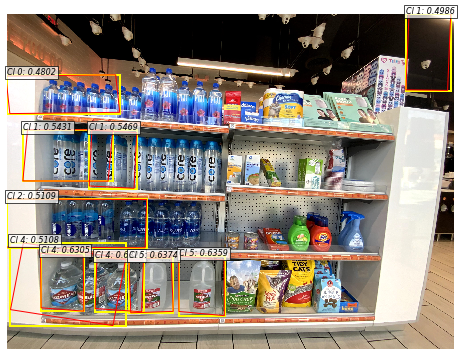

In [39]:
plt.rcParams["figure.figsize"] =(8, 8)

cfg.visualization.eval.max_detections = 10
cfg.visualization.eval.score_threshold = float("0")
visualizer.show_detections(boxes, input_image,
                           cfg.visualization.eval)


Parse Results

In [40]:
labels = boxes.get_field("labels").clone()
scores = boxes.get_field("scores").clone()

if class_ids:
    for i_detection in range(labels.size(0)):
        labels[i_detection] = int(class_ids[labels[i_detection]])
# print(scores)

good_ids = torch.nonzero(scores.float() > 0).view(-1)

_, ids = scores[good_ids].sort(descending=False)
good_ids = good_ids[ids[-10:]]
boxes = boxes[good_ids].cpu()
labels = labels[good_ids].cpu()
scores = scores[good_ids].cpu()
label_names = [ "Cl "+ str(l.item()) for l in labels]
print(label_names)

bbox_xyxy = boxes.bbox_xyxy.tolist()

['Cl 0', 'Cl 1', 'Cl 4', 'Cl 2', 'Cl 1', 'Cl 1', 'Cl 4', 'Cl 4', 'Cl 5', 'Cl 5']


Load dataset and predict the mask

In [41]:

from math import floor
from PIL import Image
# tst_image = np.array(input_image)

final_masks = {}

np_input_image = np.array(input_image)

# for indx in range(1):
for indx in range(len(labels)):
    label = labels[indx].item()
    # Crop test image
    image = input_image.crop(bbox_xyxy[indx])
    image = np.array(image)
    
    # Get target image
    target = Image.open('data/dataset2/target_' + str(label+1)+ '/target.jpg') 
    target = target.resize((192,192), Image.ANTIALIAS)
    target = np.array(target)
    
    # Run detection
    results = model.detect([[target]], [image], verbose=0)
    r = results[0]
    if not label in final_masks:
        final_masks[label] = []
    
    # Check of the detections overlap
#     cleaned_masks = []
#     print(r['rois'])
#     for i in r
    
    
    for i in range(r['masks'].shape[2]):
        mask = r['masks'][:, :, i]
        xyxy = bbox_xyxy[indx]

        mask_full = np.zeros((np_input_image.shape[0], np_input_image.shape[1]), dtype=bool)
        mask_full[round(xyxy[1]):round(xyxy[3]),round(xyxy[0]):round(xyxy[2])] = mask
        
        # Check with existing detections. If overlap
        final_masks[label].append(mask_full)

Functions for generating colors and applying mask to the image

In [42]:
def apply_mask(image, mask, color, alpha=0.5):
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image
def random_colors(N, bright=True):
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

#### Generate image segmentation

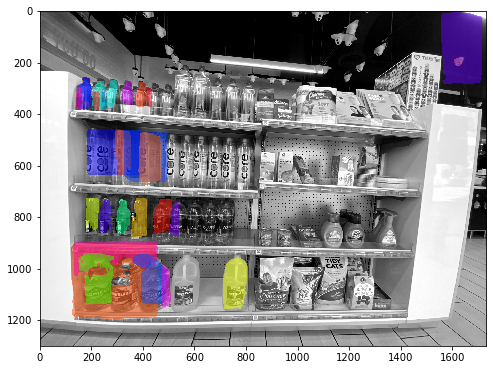

In [43]:
# Generate instance segmentation
import cv2
colors = random_colors(100)
color_idx = 20
instance_image = np.array(input_image)

instance_image = cv2.cvtColor(instance_image[:, :, ::-1].copy(), cv2.COLOR_BGR2GRAY)
instance_image = cv2.cvtColor(instance_image, cv2.COLOR_GRAY2RGB)

for label, masks in final_masks.items():
    for mask in masks:
        instance_image = apply_mask(instance_image, mask, colors[color_idx])
        color_idx += 1
        
im = Image.fromarray(instance_image)
im.save("instance_segmentation.jpeg")

plt.figure()
plt.imshow(instance_image)

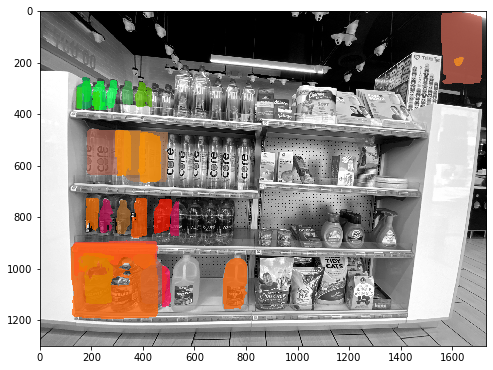

In [44]:
# Generate semantic segmentation
colors = random_colors(100)
color_idx = 10
semantic_image = np.array(input_image)
for label, masks in final_masks.items():
    for mask in masks:
        semantic_image = apply_mask(instance_image, mask, colors[color_idx])
    color_idx += 1
        
im = Image.fromarray(semantic_image)
im.save("semantic_segmentation.jpeg")

plt.figure()
plt.imshow(instance_image)